# Paper

In [1]:
import time
import itertools
import datetime
import random
import numpy as np
from copy import deepcopy
import pickle

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.initializers import glorot_normal
import keras.backend as K
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import joblib
import pandas

%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

## Definitions

In [2]:
complexity_time = np.zeros((3,))

column_size_figure = (10., 7.)

figsize_confusion = (column_size_figure[0] / 2., column_size_figure[1] / 2.)

seed = 9
random.seed(seed)
number_epochs = 1001
np.random.seed(seed)

## Functions to assist the models

In [3]:
# define baseline model for classification using neural network
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim=30, activation='linear', kernel_initializer=glorot_normal(seed))) # using linear because dataset is not normalized
    model.add(Dense(100, activation='tanh', kernel_initializer=glorot_normal(seed)))
    # for the neural network it outputs one neuron for each class, that is why a softmax activation
    model.add(Dense(7, activation='softmax', kernel_initializer=glorot_normal(seed)))
    # compile model
    # categorical_crossentropy is the loss used for multi-class classification problems
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    return model

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          colorbar=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    It uses a figure previously opened, if any.
    After calling, the figure can be modified/finalized.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm) # avoids NaN values

    # plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.pcolor(cm, cmap=cmap, edgecolors='gray')
    if title is not None:
        plt.title(title)
    plt.gca().invert_yaxis()
    if colorbar:
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks + 0.5, classes, rotation=30)
    plt.yticks(tick_marks + 0.5, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] == 0.0:
            text = '-'
        elif cm[i, j] == 1.0:
            text = '1.0'
        else:
            text = format(cm[i, j], fmt)
        plt.text(j + 0.5, i + 0.7, text,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True attack')
    plt.xlabel('Predicted attack')

In [18]:
def evaluate_models(final_dataframe, names, classifiers, class_names, prefix, train=True, cross_validate_clf=True, plots=True):
    if not train and not cross_validate:
        return None
    # splitting the dataset into each category
    split_dataset = {}
    split_dataset_values = {}

    split_dataset_X = {}
    split_dataset_Y = {}

    # creating balanced portions for training, validation and test
    # this could be more elegantly implemented using sklearn.cross_validation.StratifiedShuffleSplit
    attack_train_X = {}
    attack_train_Y = {}
    attack_validation_X = {}
    attack_validation_Y = {}
    attack_test_X = {}
    attack_test_Y = {}

    for attack_index in range(0, max_index + 1):
        split_dataset[attack_index] = final_dataframe.loc[final_dataframe['attack'] == attack_index]
        split_dataset_values[attack_index] = split_dataset[attack_index].values

        split_dataset_X[attack_index] = split_dataset_values[attack_index][:, 0:split_dataset[attack_index].shape[1] - 1].astype(float)
        split_dataset_Y[attack_index] = split_dataset_values[attack_index][:, split_dataset[attack_index].shape[1] - 1].astype(float)

        attack_train_size = 200. / len(split_dataset_values[attack_index])

        attack_train_X[attack_index], temp_X, attack_train_Y[attack_index], temp_Y = \
            train_test_split(split_dataset_X[attack_index], split_dataset_Y[attack_index], random_state=seed, train_size=attack_train_size)

        attack_validation_size = 40. / len(temp_X)

        attack_validation_X[attack_index], attack_test_X[attack_index], attack_validation_Y[attack_index], attack_test_Y[attack_index] = \
            train_test_split(temp_X, temp_Y, random_state=seed, train_size=attack_validation_size)

    X_train = attack_train_X[0]
    Y_train = attack_train_Y[0]
    X_validation = attack_validation_X[0]
    Y_validation = attack_validation_Y[0]
    X_test = attack_test_X[0]
    Y_test = attack_test_Y[0]
    for attack_index in range(1, max_index + 1):
        X_train = np.concatenate((X_train, attack_train_X[attack_index]), axis=0)
        Y_train = np.concatenate((Y_train, attack_train_Y[attack_index]), axis=0)

        X_validation = np.concatenate((X_validation, attack_validation_X[attack_index]), axis=0)
        Y_validation = np.concatenate((Y_validation, attack_validation_Y[attack_index]), axis=0)

        X_test = np.concatenate((X_test, attack_test_X[attack_index]), axis=0)
        Y_test = np.concatenate((Y_test, attack_test_Y[attack_index]), axis=0)

    h = .02  # step size in the mesh
    
    raw_dataset = final_dataframe.values
    X_raw_dataset = raw_dataset[:, 0:raw_dataset.shape[1] - 1].astype(float)
    Y_raw_dataset = raw_dataset[:, raw_dataset.shape[1] - 1].astype(int)

    scaler = StandardScaler().fit(final_dataframe.drop(['attack'], axis=1))
    X_train_transformed = scaler.transform(X_train)
    X_validation_transformed = scaler.transform(X_validation)
    X_test_transformed = scaler.transform(X_test)
    X_raw_transformed = scaler.transform(X_raw_dataset)

    # iterate over datasets
    results = {}
    for classifier in names:
        results[classifier] = {}
        for met in ['accuracy', 'training_time', 'confusion_matrix']:
            results[classifier][met] = 0.0

    # iterate over classifiers
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=36851234)
    scoring = ['accuracy', 'balanced_accuracy']

    for name, clf in zip(names, classifiers):
        
        print('evaluating', name)
        
        if name == 'ANN' and train:
            
            # KerasClassifier requires one-hot vectors as outputs
            encoder = LabelEncoder()
            encoder.fit(Y_raw_dataset)

            encoded_Y = encoder.transform(Y_train)
            Y_train_encoded = np_utils.to_categorical(encoded_Y)
            
            encoded_Y = encoder.transform(Y_validation)
            Y_validation_encoded = np_utils.to_categorical(encoded_Y)
            
            start_time = time.time_ns()
            output = clf.fit(X_train_transformed, Y_train_encoded, validation_data=(X_validation_transformed, Y_validation_encoded))
            end_time = time.time_ns()
            clf.model.save('models/' + prefix + '_' + name + '.h5')

            if plots:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(output.history['acc'], markevery=100)
                plt.plot(output.history['val_acc'], markevery=100, ls='--')
                plt.ylabel('Accuracy')
                plt.xlabel('Epoch')
                plt.grid(True, which='both', axis='y')
                plt.legend(['Train', 'Validation'], loc='lower right')

                plt.subplot(1, 2, 2)
                plt.semilogy(output.history['loss'], markevery=100)
                plt.semilogy(output.history['val_loss'], markevery=100, ls='--')
                plt.ylabel('Categorical Cross-Entropy')
                plt.xlabel('Epoch')
                plt.grid(True, which='both', axis='y')
                plt.legend(['Train', 'Validation'], loc='upper right')
                plt.tight_layout()
                plt.show()
                plt.close()

        elif train:
            start_time = time.time_ns()
            output = clf.fit(X_train_transformed, Y_train)
            end_time = time.time_ns()
            joblib.dump(clf, 'models/' + prefix + '_' + name + '.joblib')

        if train:
            y_pred = clf.predict(X_test_transformed)
            score = accuracy_score(Y_test, y_pred)
            cnf_matrix = confusion_matrix(y_pred, Y_test)
            results[name]['accuracy'] = score
            results[name]['confusion_matrix'] = cnf_matrix
            results[name]['training_time'] = end_time - start_time # training time in ns
            
            print('Accuracy (%): {:.3f}\tTraining time (ms): {}'.format(score*100., results[name]['training_time'] / 1000.))

            if plots:
                # Plot non-normalized confusion matrix
                plt.figure(figsize=figsize_confusion)
                plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                                      title='Confusion matrix for ' + name)
                plt.tight_layout()
                plt.show()
                plt.savefig('figures/' + prefix + '_matrix_' + name + '.pdf')
                plt.close()
        
        if cross_validate_clf:
            start_time = time.time_ns()
            cv_scores = cross_validate(clf, X_raw_transformed, Y_raw_dataset, cv=skf, return_train_score=True, scoring=scoring, verbose=False)
            end_time = time.time_ns()
            results[name]['cross_validation'] = cv_scores
            results[name]['cross_validation_time'] = end_time - start_time # training time in ns
#             print(cv_scores)
            print("CV training avg. accuracy (%): {:.3f} +/- {:.3f}\tCV testing avg. accuracy (%): {:.3f} +/- {:.3f}\tTraining time (ms): {}\n".format(np.mean(cv_scores['train_balanced_accuracy']), 
                                                                                    np.std(cv_scores['train_balanced_accuracy']), 
                                                                                    np.mean(cv_scores['test_balanced_accuracy']), 
                                                                                    np.std(cv_scores['test_balanced_accuracy']), 
                                                                                      np.mean(cv_scores['fit_time'])))

    return results

## Import data
Importing data from the excel file. The source data is not available due to NDA. The class is in column `attack`.

In [6]:
dataframe = pandas.read_excel("./measurements-journal-20180912.xlsx", 'attack measurement ordered', header=[0], dtype={'attack': int})

class_names = ['No Attack', 'OOB-Lig', 'OOB-Str', 'IB-Lig', 'IB-Str', 'POL-Lig', 'POL-Str']

# removing instances where some feature was not correctly captured
dataframe = dataframe[~dataframe.BER_POST_FEC.isnull()]
dataframe = dataframe[~dataframe.PDL.isnull()]

# removing all the columns that are not of interest of the problem -- also the ones only known by the transmitter
final_dataframe = dataframe.drop(['n', 'time stamp', 'OPT', 'OPT_min', 'OPT_max', 'OFT', 'OFT_min', 'OFT_max'], axis=1)

min_index = final_dataframe.attack.min()
max_index = final_dataframe.attack.max()

## Exploring dataset

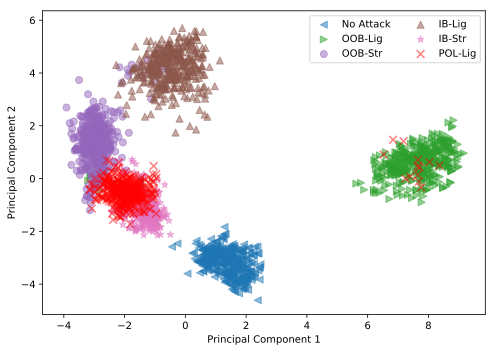

In [7]:
scaler = StandardScaler().fit(final_dataframe.drop(['attack'], axis=1))  # normalization of input values

with open('./models/scaler.h5', 'wb') as f: # save scaler to use for the generation of new samples
    pickle.dump(scaler, f)

pca = PCA(n_components=2)
x_scaled = scaler.transform(final_dataframe.drop(['attack'], axis=1))
principalComponents = pca.fit_transform(x_scaled)
principalDf = pandas.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf = pandas.concat([principalDf, final_dataframe[['attack']]], axis=1)
plt.figure(figsize=(7, 5))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#e377c2']
markers = ['<', 's', '>', 'o', '^', '*', 'v']
for id, color in enumerate(colors):
    if id == 1:
        continue
    indicesToKeep = finalDf['attack'] == id
    plt.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                    , finalDf.loc[indicesToKeep, 'principal component 2']
                    , c=color, marker=markers[id]
                    , s=50, alpha=0.5)
indicesToKeep = finalDf['attack'] == 1
# ds = finalDf.loc[indicesToKeep]
# anomalous_indices = np.random.choice([x for x in range(0, len(ds))], size=15)
# print('indices to keep:', len(indicesToKeep), indicesToKeep)
# print('samples:', len(finalDf.loc[indicesToKeep, 'principal component 1'].sample(n=15)), finalDf.loc[indicesToKeep, 'principal component 1'].sample(n=15))
samples = finalDf.loc[indicesToKeep]
plt.scatter(samples['principal component 1']
            , samples['principal component 2']
            , c='red', marker='x', alpha=.5
            , s=60)

plt.legend(class_names, ncol=2)
plt.grid(False)
plt.tight_layout()
plt.show()
plt.close()

## Define the classifiers used

In [8]:
names = [
            "ANN",
             "kNN",
             "SVM",
             "GP",
             "DT",
             "RF",
             "NB",
             "QDA"
             ]

classifiers = [
        KerasClassifier(build_fn=baseline_model, epochs=number_epochs, batch_size=200, verbose=0, shuffle=True),
        KNeighborsClassifier(),
        SVC(degree=3, gamma='auto'),
        GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()
    ]

## Running the training for the full dataset

evaluating ANN
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


<Figure size 1944x648 with 0 Axes>

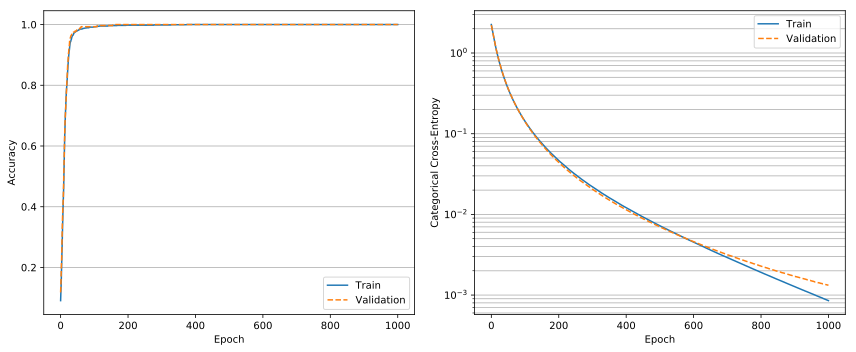

Accuracy (%): 100.000	Training time (ms): 13581269.97


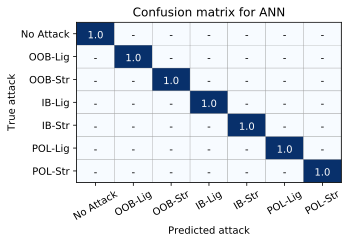

evaluating kNN
Accuracy (%): 98.910	Training time (ms): 5552.636


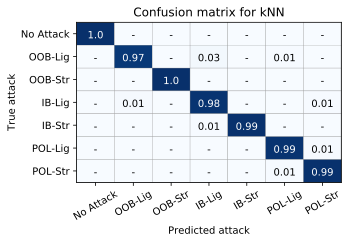

evaluating SVM
Accuracy (%): 99.728	Training time (ms): 20765.606


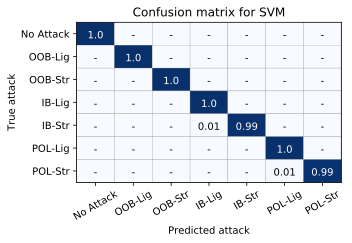

evaluating GP
Accuracy (%): 99.909	Training time (ms): 124262648.001


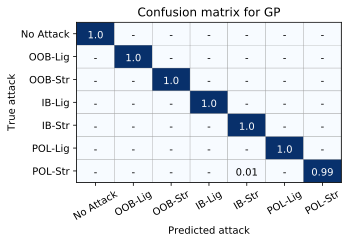

evaluating DT
Accuracy (%): 99.364	Training time (ms): 3974.347


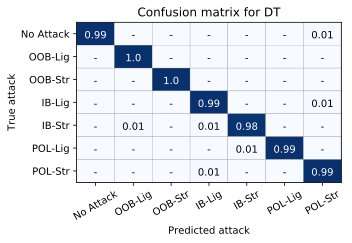

evaluating RF
Accuracy (%): 99.455	Training time (ms): 6058.828


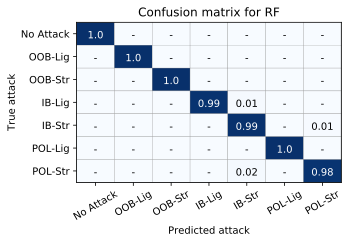

evaluating NB
Accuracy (%): 99.273	Training time (ms): 1587.766


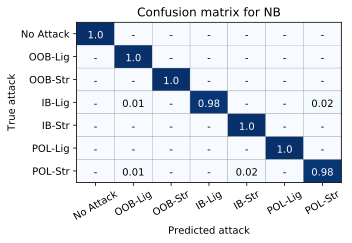

evaluating QDA
Accuracy (%): 92.916	Training time (ms): 5036.642


/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


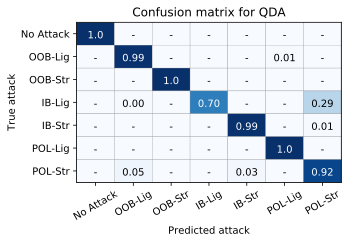

In [9]:
suffix = 'full_dataset'
results_full_features = evaluate_models(final_dataframe, names, classifiers, class_names, suffix, cross_validate_clf=False)

## Plotting a summary of the training/testing metrics

8 8


/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


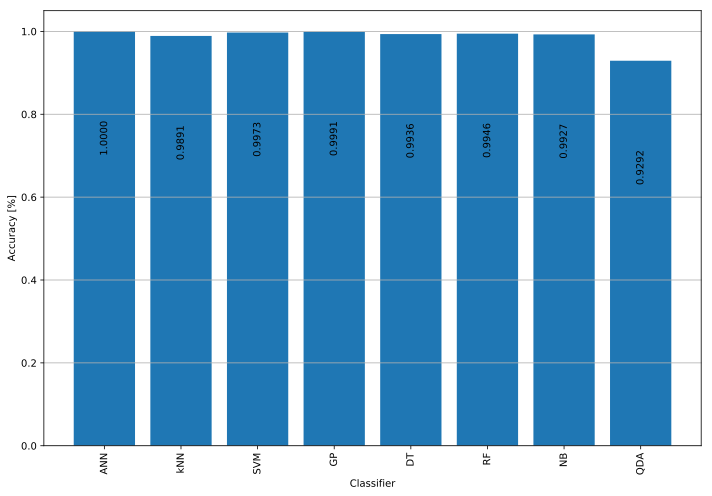

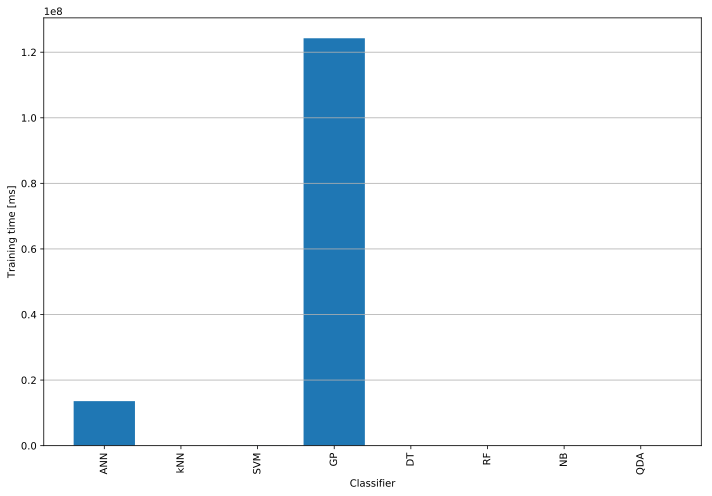

In [10]:
# also plot here a bar plot with the last performance
plt.figure(figsize=column_size_figure)
y = [results_full_features[x]['accuracy'] for x in results_full_features]
print(len(y), len(np.arange(1, len(classifiers)+1)))
rects = plt.bar(range(1, len(y)+1), y)

for rect in rects:
    height = rect.get_height()
    plt.axes().text(rect.get_x() + rect.get_width()/2., height - .3,
                    '{:.4f}'.format(height),
                    ha='center', va='bottom', rotation=90)

plt.ylabel("Accuracy [%]")
plt.xlabel("Classifier")
plt.xticks(range(1, len(y)+1), names, rotation=90)
plt.grid(True, axis='y', which='both')
plt.tight_layout()
plt.savefig('figures/' + suffix + '_accuracy_summary.pdf')
plt.show()
plt.close()

plt.figure(figsize=column_size_figure)
y = [results_full_features[x]['training_time'] / 1000. for x in results_full_features]
rects = plt.bar(range(1, len(y)+1), y)
plt.ylabel("Training time [ms]")
plt.xlabel("Classifier")

# for rect in rects:
#     height = rect.get_height()
#     plt.axes().text(rect.get_x() + rect.get_width()/2., height - .3,
#                     '{:.2f}'.format(height),
#                     ha='center', va='bottom', rotation=90)

plt.xticks(range(1, len(y)+1), names, rotation=90)
plt.grid(True, axis='y', which='both')
plt.tight_layout()
plt.savefig('figures/' + suffix + '_training_time.pdf')
plt.show()
plt.close()

## Running the cross-validation of the models

In [11]:
suffix = 'cross_validation'
results_cross_validation = evaluate_models(final_dataframe, names, classifiers, class_names, suffix, train=False)

evaluating ANN
CV training avg. accuracy (%): 1.000 +/- 0.000	CV testing avg. accuracy (%): 0.999 +/- 0.001	Training time (ms): 22.102405738830566

evaluating kNN
CV training avg. accuracy (%): 0.990 +/- 0.001	CV testing avg. accuracy (%): 0.985 +/- 0.007	Training time (ms): 0.001880812644958496

evaluating SVM
CV training avg. accuracy (%): 0.999 +/- 0.000	CV testing avg. accuracy (%): 0.997 +/- 0.004	Training time (ms): 0.03520877361297607

evaluating GP
CV training avg. accuracy (%): 1.000 +/- 0.000	CV testing avg. accuracy (%): 0.999 +/- 0.002	Training time (ms): 646.1436353206634

evaluating DT
CV training avg. accuracy (%): 0.999 +/- 0.000	CV testing avg. accuracy (%): 0.997 +/- 0.003	Training time (ms): 0.006283378601074219

evaluating RF
CV training avg. accuracy (%): 0.997 +/- 0.002	CV testing avg. accuracy (%): 0.995 +/- 0.005	Training time (ms): 0.006989908218383789

evaluating NB
CV training avg. accuracy (%): 0.995 +/- 0.000	CV testing avg. accuracy (%): 0.994 +/- 0.005	Tr

/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sk

<Figure size 1944x648 with 0 Axes>

/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


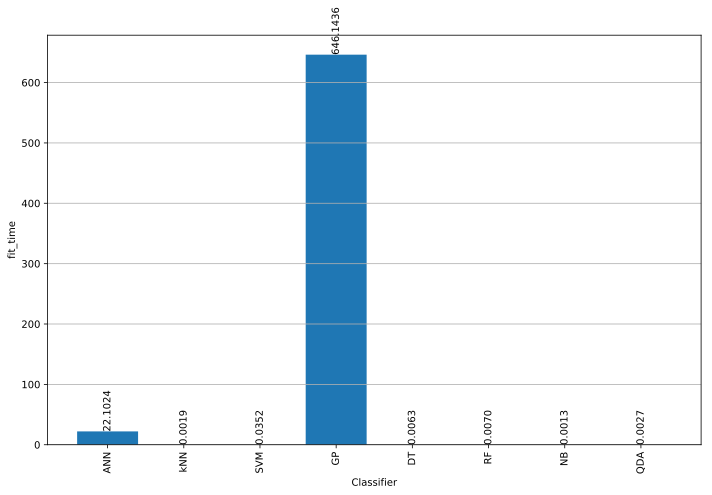

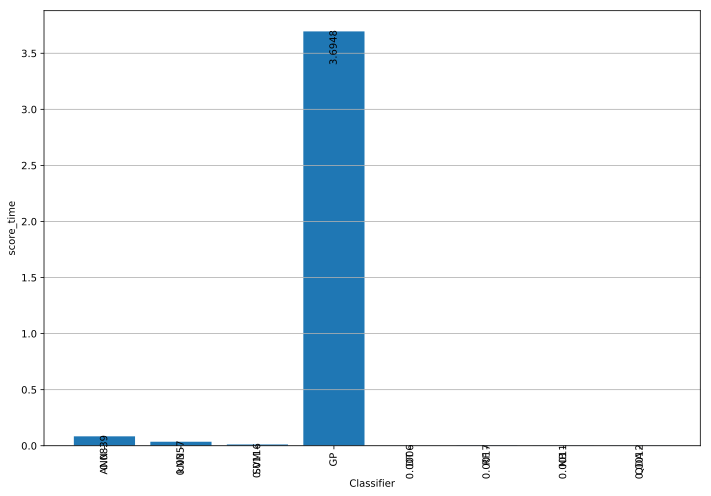

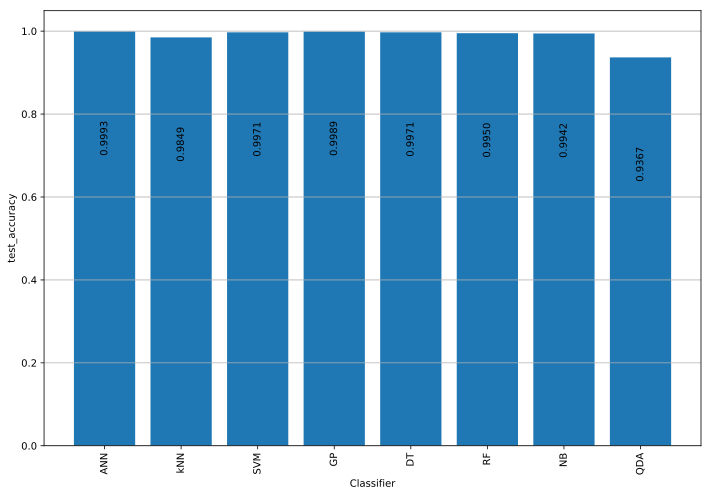

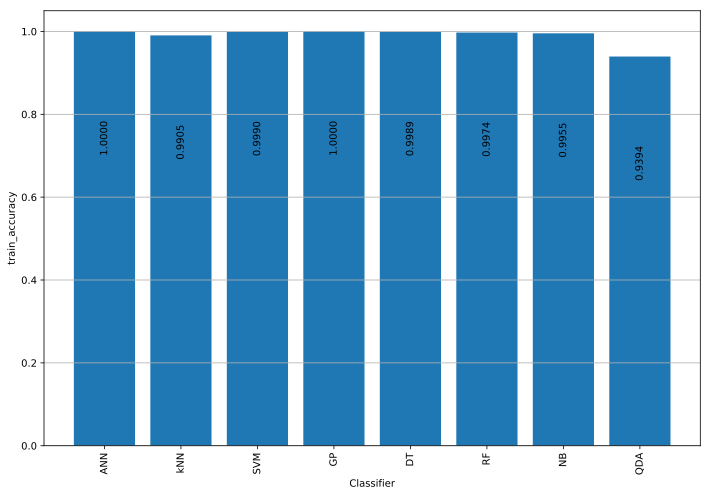

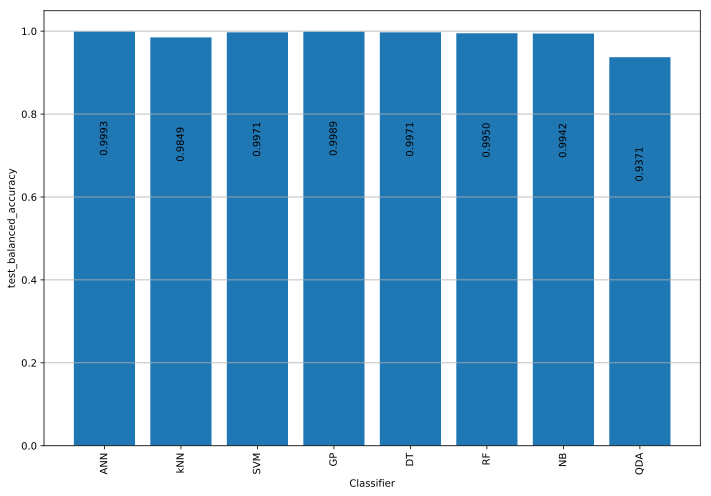

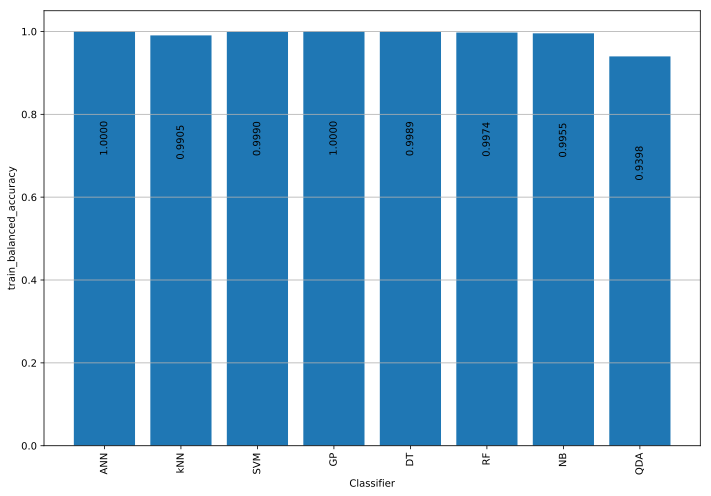

In [12]:
# also plot here a bar plot with the last performance
cross_val_metrics = None
for x in results_full_features:
    cross_val_metrics = results_cross_validation[x]['cross_validation'].keys()
    break

for cvm in cross_val_metrics:
    plt.figure(figsize=column_size_figure)
    y = [results_cross_validation[x]['cross_validation'][cvm].mean() for x in results_full_features]
#     print(len(y), len(np.arange(1, len(classifiers)+1)))
    rects = plt.bar(range(1, len(y)+1), y)

    for rect in rects:
        height = rect.get_height()
        plt.axes().text(rect.get_x() + rect.get_width()/2., height - .3,
                        '{:.4f}'.format(height),
                        ha='center', va='bottom', rotation=90)

    plt.ylabel(cvm)
    plt.xlabel("Classifier")
    plt.xticks(range(1, len(y)+1), names, rotation=90)
    plt.grid(True, axis='y', which='both')
    plt.tight_layout()
    plt.savefig('figures/' + suffix + '_cross_val_' + cvm + '.pdf')
    plt.show()
    plt.close()

## Computing the results for the case where features are missing

In [20]:
results_missing_features = {}
for column in final_dataframe.columns:
    if 'min' not in column and 'max' not in column and 'attack' not in column:  # min and max columns are not part of this test
        results_missing_features[column] = {}
        for classifier in names:
            results_missing_features[column][classifier] = {}
            for met in ['accuracy', 'training_time']:
                results_missing_features[column][classifier][met] = 0.0

for column in results_missing_features:
    print('\nrunning experiment for column: ', column)
    temp_dataframe = deepcopy(final_dataframe)
    if column + '_min' in final_dataframe.columns:  # we should remove also the min and max columns
        temp_dataframe[column] = 0.
        temp_dataframe[column + '_min'] = 0.
        temp_dataframe[column + '_max'] = 0.
    else:
        temp_dataframe[column] = 0.
    results_missing_features[column] = evaluate_models(temp_dataframe, names, classifiers, class_names, 'missing_' + column, cross_validate_clf=False, plots=False)


running experiment for column:  BE_FEC
evaluating ANN
Accuracy (%): 100.000	Training time (ms): 30294892.03
evaluating kNN
Accuracy (%): 99.092	Training time (ms): 4062.568
evaluating SVM
Accuracy (%): 99.728	Training time (ms): 34315.469
evaluating GP
Accuracy (%): 99.909	Training time (ms): 261730940.964
evaluating DT
Accuracy (%): 99.364	Training time (ms): 12392.024
evaluating RF
Accuracy (%): 99.818	Training time (ms): 6366.531
evaluating NB
Accuracy (%): 99.273	Training time (ms): 4332.422
evaluating QDA
Accuracy (%): 92.916	Training time (ms): 6846.006

running experiment for column:  BER_FEC
evaluating ANN


/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy (%): 99.818	Training time (ms): 38864316.888
evaluating kNN
Accuracy (%): 97.003	Training time (ms): 1239.287
evaluating SVM
Accuracy (%): 99.546	Training time (ms): 34083.844
evaluating GP
Accuracy (%): 99.728	Training time (ms): 253279040.075
evaluating DT
Accuracy (%): 98.547	Training time (ms): 15444.013
evaluating RF
Accuracy (%): 99.455	Training time (ms): 13012.047
evaluating NB
Accuracy (%): 99.092	Training time (ms): 10239.098
evaluating QDA
Accuracy (%): 93.006	Training time (ms): 9437.716

running experiment for column:  BER_POST_FEC
evaluating ANN


/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy (%): 99.455	Training time (ms): 39016973.177
evaluating kNN
Accuracy (%): 97.911	Training time (ms): 3083.778
evaluating SVM
Accuracy (%): 99.546	Training time (ms): 35855.369
evaluating GP
Accuracy (%): 99.546	Training time (ms): 238218757.82
evaluating DT
Accuracy (%): 99.546	Training time (ms): 12511.638
evaluating RF
Accuracy (%): 99.092	Training time (ms): 12877.244
evaluating NB
Accuracy (%): 99.001	Training time (ms): 5974.947
evaluating QDA
Accuracy (%): 97.911	Training time (ms): 9878.609

running experiment for column:  UBE_FEC
evaluating ANN


/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy (%): 100.000	Training time (ms): 40119342.012
evaluating kNN
Accuracy (%): 99.001	Training time (ms): 5233.588
evaluating SVM
Accuracy (%): 99.728	Training time (ms): 37787.546
evaluating GP
Accuracy (%): 99.909	Training time (ms): 255034865.919
evaluating DT
Accuracy (%): 99.364	Training time (ms): 12280.683
evaluating RF
Accuracy (%): 99.637	Training time (ms): 12369.326
evaluating NB
Accuracy (%): 99.273	Training time (ms): 5927.005
evaluating QDA
Accuracy (%): 91.735	Training time (ms): 10182.435

running experiment for column:  LOSS
evaluating ANN


/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy (%): 100.000	Training time (ms): 35943992.557
evaluating kNN
Accuracy (%): 98.910	Training time (ms): 1746.942
evaluating SVM
Accuracy (%): 99.728	Training time (ms): 35998.529
evaluating GP
Accuracy (%): 99.909	Training time (ms): 258077916.195
evaluating DT
Accuracy (%): 99.364	Training time (ms): 10459.304
evaluating RF
Accuracy (%): 99.001	Training time (ms): 8441.837
evaluating NB
Accuracy (%): 99.273	Training time (ms): 14270.488
evaluating QDA
Accuracy (%): 92.916	Training time (ms): 10010.792

running experiment for column:  OPR
evaluating ANN


/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy (%): 99.909	Training time (ms): 36487605.689
evaluating kNN
Accuracy (%): 96.094	Training time (ms): 4781.483
evaluating SVM
Accuracy (%): 99.455	Training time (ms): 39738.003
evaluating GP
Accuracy (%): 99.909	Training time (ms): 294450344.52
evaluating DT
Accuracy (%): 99.364	Training time (ms): 12341.184
evaluating RF
Accuracy (%): 99.273	Training time (ms): 12825.78
evaluating NB
Accuracy (%): 98.456	Training time (ms): 4891.529
evaluating QDA
Accuracy (%): 92.916	Training time (ms): 6807.555

running experiment for column:  CD
evaluating ANN


/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy (%): 100.000	Training time (ms): 36729031.148
evaluating kNN
Accuracy (%): 99.273	Training time (ms): 5292.934
evaluating SVM
Accuracy (%): 99.818	Training time (ms): 27620.208
evaluating GP
Accuracy (%): 100.000	Training time (ms): 197468021.599
evaluating DT
Accuracy (%): 99.364	Training time (ms): 6224.388
evaluating RF
Accuracy (%): 99.455	Training time (ms): 12599.326
evaluating NB
Accuracy (%): 99.273	Training time (ms): 10014.203
evaluating QDA
Accuracy (%): 92.734	Training time (ms): 9783.431

running experiment for column:  DGD
evaluating ANN


/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy (%): 99.637	Training time (ms): 37211130.557
evaluating kNN
Accuracy (%): 96.821	Training time (ms): 1905.672
evaluating SVM
Accuracy (%): 99.273	Training time (ms): 42962.417
evaluating GP
Accuracy (%): 99.455	Training time (ms): 230125149.765
evaluating DT
Accuracy (%): 99.637	Training time (ms): 8001.046
evaluating RF
Accuracy (%): 99.637	Training time (ms): 12605.82
evaluating NB
Accuracy (%): 96.458	Training time (ms): 10082.308
evaluating QDA
Accuracy (%): 92.734	Training time (ms): 6869.044

running experiment for column:  OFR
evaluating ANN


/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy (%): 100.000	Training time (ms): 37152974.848
evaluating kNN
Accuracy (%): 98.910	Training time (ms): 1128.178
evaluating SVM
Accuracy (%): 99.728	Training time (ms): 32695.62
evaluating GP
Accuracy (%): 99.909	Training time (ms): 257177213.563
evaluating DT
Accuracy (%): 99.364	Training time (ms): 9964.892
evaluating RF
Accuracy (%): 98.819	Training time (ms): 12257.726
evaluating NB
Accuracy (%): 99.273	Training time (ms): 6264.198
evaluating QDA
Accuracy (%): 92.916	Training time (ms): 10176.238

running experiment for column:  OSNR
evaluating ANN


/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy (%): 99.818	Training time (ms): 37799945.154
evaluating kNN
Accuracy (%): 98.274	Training time (ms): 7038.128
evaluating SVM
Accuracy (%): 99.818	Training time (ms): 35934.465
evaluating GP
Accuracy (%): 99.909	Training time (ms): 235369599.271
evaluating DT
Accuracy (%): 99.183	Training time (ms): 6769.634
evaluating RF
Accuracy (%): 99.364	Training time (ms): 12663.57
evaluating NB
Accuracy (%): 99.001	Training time (ms): 5761.839
evaluating QDA
Accuracy (%): 92.825	Training time (ms): 10077.909

running experiment for column:  PDL
evaluating ANN


/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy (%): 100.000	Training time (ms): 38067951.554
evaluating kNN
Accuracy (%): 98.638	Training time (ms): 4812.71
evaluating SVM
Accuracy (%): 99.728	Training time (ms): 36402.22
evaluating GP
Accuracy (%): 100.000	Training time (ms): 229862031.166
evaluating DT
Accuracy (%): 99.909	Training time (ms): 12028.708
evaluating RF
Accuracy (%): 100.000	Training time (ms): 8509.961
evaluating NB
Accuracy (%): 99.637	Training time (ms): 14376.805
evaluating QDA
Accuracy (%): 92.371	Training time (ms): 9965.912

running experiment for column:  Q_factor
evaluating ANN


/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy (%): 100.000	Training time (ms): 39645114.014
evaluating kNN
Accuracy (%): 97.275	Training time (ms): 1311.971
evaluating SVM
Accuracy (%): 99.909	Training time (ms): 36958.991
evaluating GP
Accuracy (%): 99.909	Training time (ms): 204194335.447
evaluating DT
Accuracy (%): 99.455	Training time (ms): 11919.777
evaluating RF
Accuracy (%): 99.637	Training time (ms): 8863.195
evaluating NB
Accuracy (%): 99.546	Training time (ms): 14137.525
evaluating QDA
Accuracy (%): 94.005	Training time (ms): 10034.949


/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


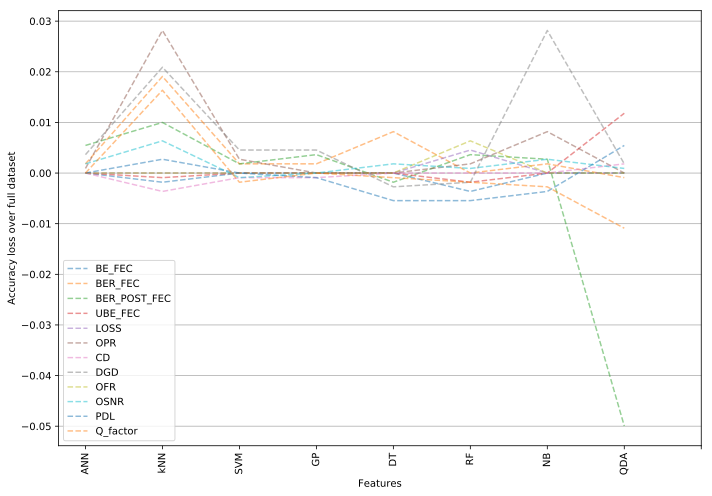

In [32]:
plt.figure(figsize=column_size_figure)
for column in results_missing_features:
    plt.plot([results_full_features[classifier]['accuracy'] - results_missing_features[column][classifier]['accuracy'] for classifier in results_missing_features[column]], label=column, linestyle='--', alpha=0.5)
plt.ylabel("Accuracy loss over full dataset")
plt.xlabel("Features")
plt.xticks(range(0, len(names)+1), names, rotation=90)
plt.legend()
plt.grid(True, axis='y', which='both')
plt.tight_layout()
# plt.savefig('figure/missing_features_accuracy_summary.pdf')
plt.show()

## Saving all the results

In [22]:
with open('models/results_final.h5', 'wb') as f:
    pickle.dump({'full': results_full_features, 
                 'cross_validation': results_cross_validation,
                 'missing': results_missing_features}, f)